# Seating optimization

This notebook is an implementation of a simple stochastic algorithm to find a (quasi-) optimal solution for assigning guests to tables at events like weddings. It assumes that every pair of guests as a certain "favorability" score based on how well (or poorly) they can be expected to get along. It assigns each guest to a table with the goal of maximizing the total favorability of guests sitting at the same table. This problem is #very# computationally hard to solve exactly for any non-trivial number of guests, but even a very naive, simple optimization algorithm does a pretty good job, pretty quickly. Note: this is not quite done, but close.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from itertools import combinations
import matplotlib.pyplot as plt

### Importing guests

First, we need to import the list of guest names at the wedding. I've used as a default a list of 13 guests. If you want to use your own list, edit `sample_names.csv` putting one name in each row, or use a csv in similar format, replacing the reference to the file name below.

In [2]:
names = pd.read_csv("sample_names.csv")
display(names)

,Name
0,Alice
1,Bob
2,Charlie
3,David
4,Eliza
5,Frank
6,Greg
7,Heather
8,Igor
9,Jack


What we care about, though, is the interactions _between_ each pair of guests. We can visualize that by rearranging the guest list into an upper triangular matrix.

In [3]:
pairs = pd.DataFrame(0.0,index=names.values[:,0],columns=names.values[:,0])
pairs = pairs.where(np.triu(np.ones(pairs.shape),1).astype(np.bool))
display(pairs)

,Alice,Bob,Charlie,David,Eliza,Frank,Greg,Heather,Igor,Jack,Kelly,Larry,Mary
Alice,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bob,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Charlie,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
David,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eliza,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frank,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Greg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
Heather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
Igor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
Jack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In order to actually enter in and process this data, though, it can be helpful to "unstack" these pairs into list form. Below, I turn the pairs into a list and save it to `pairs.csv`, which can be edited in order to enter in the suitability of each pair of guests.

In [4]:
pairs = pairs.stack().reset_index()
pairs.columns = ['Person1','Person2','Suitability']
display(pairs)
pairs.to_csv('pairs.csv')

,Person1,Person2,Suitability
0,Alice,Bob,0.0
1,Alice,Charlie,0.0
2,Alice,David,0.0
3,Alice,Eliza,0.0
4,Alice,Frank,0.0
5,Alice,Greg,0.0
6,Alice,Heather,0.0
7,Alice,Igor,0.0
8,Alice,Jack,0.0
9,Alice,Kelly,0.0


After you've entered in as many pairwise suitability scores as you want, you can read the data back in. I've also given the option of randomly generating some suitability scores, with some couples that should be seated together, some people who (due to sordid history) should not sit together, and the rest of pairs mildly positive or negative.

In [14]:
newpairs = pd.read_csv('pairs.csv',index_col=0)

# COMMENT OUT THESE NEXT THREE LINES IF YOU'VE ENTERED IN YOUR OWN SCORES
newpairs['Suitability'] = np.random.uniform(-0.25,0.25,size=newpairs['Suitability'].size)
newpairs.loc[newpairs.sample(frac=0.1).index,'Suitability'] = 1
newpairs.loc[newpairs.sample(frac=0.02).index,'Suitability'] = -1
#

costMatrix = newpairs.set_index(['Person1', 'Person2']).unstack()
display(costMatrix)
costMatrix = costMatrix.values

Suitability                                                    \
Person2         Bob   Charlie     David     Eliza     Frank      Greg   
Person1                                                                 
Alice      0.109741 -0.019292 -0.175107 -0.058856  0.178300  0.064591   
Bob             NaN -0.086171 -0.133953  0.133485 -0.042289  0.198075   
Charlie         NaN       NaN  0.007236 -1.000000  0.184230  1.000000   
David           NaN       NaN       NaN -0.193905  1.000000 -0.073821   
Eliza           NaN       NaN       NaN       NaN -0.065748  0.064885   
Frank           NaN       NaN       NaN       NaN       NaN -0.091046   
Greg            NaN       NaN       NaN       NaN       NaN       NaN   
Heather         NaN       NaN       NaN       NaN       NaN       NaN   
Igor            NaN       NaN       NaN       NaN       NaN       NaN   
Jack            NaN       NaN       NaN       NaN       NaN       NaN   
Kelly           NaN       NaN       NaN       NaN       NaN       NaN   
Larry           NaN       NaN       NaN       NaN       NaN       NaN   

                                                                     
Person2   Heather      Igor      Jack     Kelly     Larry      Mary  
Person1                                                              
Alice    0.165342  0.000084 -0.183214 -0.019809  0.030040 -0.028370  
Bob     -0.202702  1.000000  0.095435  0.242007  0.193738 -0.219184  
Charlie  0.121013  0.037424  0.139765 -0.128167  0.016301  0.111290  
David    0.097917  0.148401 -0.148184  0.097580  1.000000  1.000000  
Eliza   -0.162798 -0.090282 -0.186441 -0.042199  0.087165  0.151081  
Frank   -0.117604  0.183763 -0.181192  0.192700  0.122739 -0.010004  
Greg     1.000000  0.186576  0.223904 -0.024386  0.242752 -1.000000  
Heather       NaN  0.204635 -0.180534  0.144027  1.000000  0.211942  
Igor          NaN       NaN  0.031715  0.182754  0.009791  1.000000  
Jack          NaN       NaN       NaN -0.215075  0.042183  0.108129  
Kelly         NaN       NaN       NaN       NaN -0.148165  0.218992  
Larry         NaN       NaN       NaN       NaN       NaN  0.033564

In order to set up the problem, we need to define the number of tables and the maximum number of guests for each (for simplicity, I'm assuming all tables are the same size). Here, we assume 3 tables of 5 people for 13 guests, meaning that two table spots are left empty. These are filled with empty chairs.

In [15]:
nTables = 3
tableSize = 5


nEmptyChairs = nTables*tableSize - names.size
allNames = names.copy()
for i in range(names.size,nTables*tableSize):
    allNames.loc[i] = "Empty Chair" 
fullCostMatrix = np.pad(costMatrix,((0,nEmptyChairs+1),(1,nEmptyChairs)), mode='constant', constant_values=0)
allNames['Table']=np.random.permutation(np.arange(allNames.size)/tableSize)
display(allNames)

,Name,Table
0,Alice,1
1,Bob,1
2,Charlie,0
3,David,2
4,Eliza,0
5,Frank,2
6,Greg,2
7,Heather,1
8,Igor,0
9,Jack,0


In [16]:
setup_details = dict(costs = fullCostMatrix, nTables = nTables, tableSize = tableSize)
class arrangement:
    def __init__(self,guests,setup_details):
        self.guests = guests
        self.costs = setup_details["costs"]
        self.nTables = setup_details["nTables"]
        self.tableSize = setup_details["tableSize"]
        self.favorability = np.nan
        self.previous_favorability = np.nan
        self.randomize_tables()
    def randomize_tables(self):
        self.tables = np.random.permutation(np.arange(self.guests.size)/self.tableSize)
        self.calculate_favorability()
    def calculate_favorability(self):
        xv, yv = np.meshgrid(self.tables, self.tables)
        self.favorability = np.nansum(self.costs[(xv == yv)*(np.triu(np.ones(self.costs.shape,dtype=bool),1))])
    def randomly_swap(self):
        #self.previous_favorability = self.favorability
        keepGoing = True
        while keepGoing:
            inds = np.random.choice(self.guests.size, 2, replace=False)
            if self.tables[inds[0]] != self.tables[inds[1]]:
                keepGoing = False
        temp = self.tables[inds[0]].copy()
        self.tables[inds[0]] = self.tables[inds[1]].copy()
        self.tables[inds[1]] = temp
        self.calculate_favorability()
    def adopt_new_arrangement(self,arrangement):
        self.tables = arrangement.tables.copy()
        self.favorability = arrangement.favorability.copy()

In [17]:
def simple_acceptance_function(cost1,cost2,temperature):
    if cost2 > cost1:
        return True
    else:
        return False
    
def annealing_acceptance_function(cost1,cost2,temperature):
    a = np.exp((cost2 - cost1)/temperature)
    if a >= 1:
        return True
    else:
        return np.random.random_sample() < a

def iterate(arr1,arr2,temperature):
    #arr2.randomly_swap()
    arr1.previous_favorability = arr1.favorability
    swap = annealing_acceptance_function(arr1.favorability,arr2.favorability,temperature)
    if swap:
        arr1.adopt_new_arrangement(arr2)
    else:
        arr2.adopt_new_arrangement(arr1)
    arr2.randomly_swap()

In [20]:
arr1 = arrangement(allNames["Name"].values,setup_details)
arr2 = arrangement(allNames["Name"].values,setup_details)
arr_best = arrangement(allNames["Name"].values,setup_details)
arr2.adopt_new_arrangement(arr1)
arr_best.adopt_new_arrangement(arr1)
arr2.randomly_swap()

/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


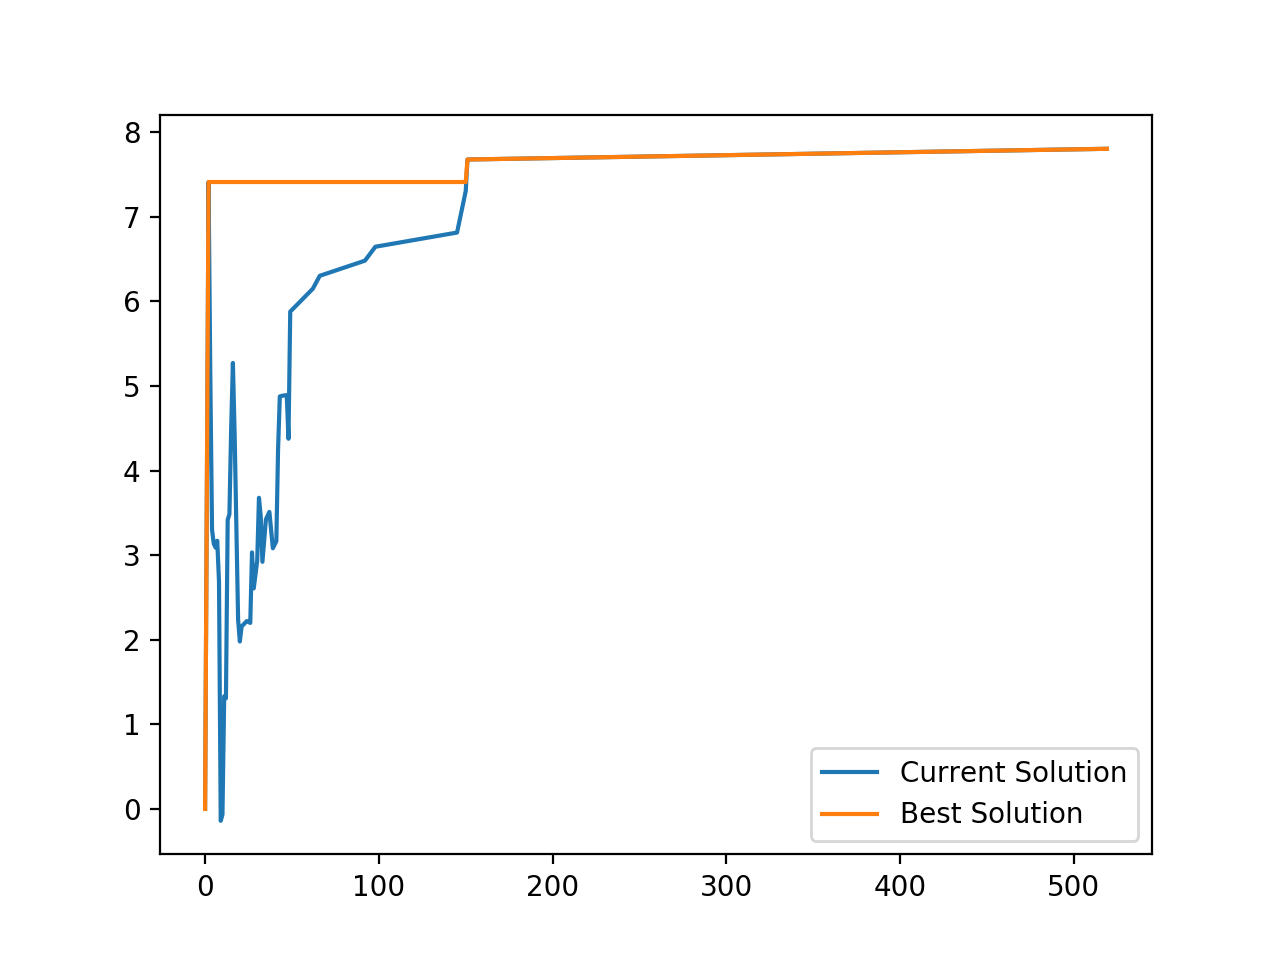

In [26]:
time = np.zeros([1],int)
current_solution = np.zeros([1],float)
best_solution = np.zeros([1],float)
for i in range(100000):
    temperature = 50/(i+1)
    iterate(arr1,arr2,temperature)
    if arr1.previous_favorability != arr1.favorability:
        time = np.append(time,i)
        current_solution = np.append(current_solution,arr1.favorability)
        if arr1.favorability > best_solution[-1]:
            arr_best.adopt_new_arrangement(arr1)
        best_solution = np.append(best_solution,max(arr1.favorability,best_solution[-1]))
    if (i - time[-1]) > 10000:
        break
plt.plot(time,current_solution,label='Current Solution')
plt.plot(time,best_solution,label='Best Solution')
plt.legend()

In [28]:
df = pd.DataFrame(arr_best.guests,columns = ['Name'])
df["Table"] = np.apply_along_axis(lambda y: ["Table " + str(i+1) for i in y], 0, arr_best.tables)
newdf = pd.DataFrame()
for key, values in df.groupby("Table").groups.iteritems():
    newdf[key] = df["Name"].loc[values].values
newdf = newdf.reindex(sorted(newdf.columns), axis=1)
display(newdf)

,Table 1,Table 2,Table 3
0,Charlie,David,Alice
1,Greg,Frank,Bob
2,Heather,Igor,Eliza
3,Jack,Kelly,Empty Chair
4,Larry,Mary,Empty Chair
